# lda models
- https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0


#tfidf https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76


https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


# 1. Getting started
## 1.1. Import packages

In [1]:
# maths
from collections import Counter
from numpy import array, log
from scipy.stats import entropy
import pandas as pd
import numpy as np

# grapjs
import seaborn as sns
import matplotlib.pyplot as plt

# text editing
import os
import re
import string
import unidecode

# gensim
import gensim
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel, Phrases, Word2Vec
from gensim.models.phrases import Phraser
from gensim.models.word2vec import FAST_VERSION
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim.utils import simple_preprocess

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder

from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

# sklearn
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.manifold import TSNE

# LDA visualization
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis


import pickle
import warnings

unable to import 'smart_open.gcs', disabling that module


## 1.2. Pre-processing text

In [2]:
def clean_corpus(corpus):
    """
    input = list of strings
    task = cut blanks / titles
    output = list of strings
    """
    clean_corpus = []
    skip_next = False
    # clean
    for line in corpus:
        if line == '':
            continue
        if skip_next:
            skip_next = False
            continue
        if line[:8] == 'CAPITULO':
            skip_next = True
            continue
        if len(line)<=5:
            continue
        clean_corpus.append(line)
    return clean_corpus
    
def gimme_paragraphs(corpus):
    """
    input = list of strings
    task = group sentences into paragraphs
    output = list of strings
    """
    paragraphs = []
    sup = []
    for line in corpus:
        sup.append(line)
        if line[-1] in {'.','!','?',':'}:
            # um paragrafo = uma string
            sup = ' '.join(s for s in sup)[:-1]
            # '-' vira ' '
            sup = re.sub(r'[-]',' ',sup)
            paragraphs.append(sup)
            sup = []
    return paragraphs
    
def clean_sentence(words,stop_words=set()):
    """
    input = list of list of strings
    task = clean words
    output = list of list of strings
    """
    
    # palavras (minuscula, ex pontuaçao)

    words = [re.sub(r'['+string.punctuation+']','',word.lower()) for word in words]
    # take accents out
    words = [unidecode.unidecode(word) for word in words]
    # non alphabet charcs
    words = [re.sub('[^a-z]',' ',word) for word in words if word != '']
    # trash
    words = [word for word in words if len(word) > 2]
    # stop words
    if len(stop_words)>0:
        words = [word for word in words if word not in stop_words]
    # take blank lines out
    words = [word for word in words if word != '']
    words = [word for word in words if word != ' ']
    return words

In [3]:
# obras
folder = 'Machado/'
titles = os.listdir(folder)

# 5 obras de Machado de Assis
# cuidado! originais! outra norma ortografia!
print(titles)

# abrir documento
corpus = []
for title in titles:
    corpus += open(folder+title,'r',encoding='utf-8-sig').read().split('\n')
corpus = clean_corpus(corpus)

# paragrafos
paragraphs = gimme_paragraphs(corpus)
print('# de paragrafos:',len(paragraphs))

# frases como string
paragraphs_sents = [sent_tokenize(p) for p in paragraphs]
sentences = [item for sublist in paragraphs_sents for item in sublist]
print('# de frases:',len(sentences))

# frases como lista de strings
sentences_words = [word_tokenize(s) for s in sentences]

# frases com stop_words (mas sem pontuaçao etc)
sentences_dirty = [clean_sentence(words,stop_words={}) for words in sentences_words]
words_dirty = [item for sublist in sentences_dirty for item in sublist]
print('# de palavras (sujo):',len(words_dirty))

# stop words
stop_words = [unidecode.unidecode(word) for word in stopwords.words('portuguese')]
stop_words += ['elle','ella']

# frases sem stop words
sentences_clean = [clean_sentence(words,set(stop_words)) for words in sentences_words]
words_clean = [item for sublist in sentences_clean for item in sublist]
print('# de palavras (limpo):',len(words_clean))

['BrazCubas.txt', 'DomCasmurro.txt', 'EsauJacob.txt', 'MaoLuva.txt', 'QuincasBorba.txt']
# de paragrafos: 7704
# de frases: 20081
# de palavras (sujo): 225197
# de palavras (limpo): 163251


In [4]:
# com stop-words
df_all = pd.DataFrame(pd.DataFrame(words_dirty,columns=['counts'])['counts'].value_counts()).reset_index().rename(columns={'index':'words'})

# o primeiro substantivo é a 30a palavra
print(df_all[df_all.words=='virgilia'])
df_all.head(10)

        words  counts
149  virgilia     199


,words,counts
0,que,11687
1,nao,6457
2,lhe,2787
3,era,2614
4,com,2585
5,mas,2516
6,uma,2396
7,para,2352
8,por,1601
9,mais,1515


In [5]:
# sem stop words
df_non = pd.DataFrame(pd.DataFrame(words_clean,columns=['counts'])['counts'].value_counts()).reset_index().rename(columns={'index':'words'})

# o primeiro substantivo é a 1a palavra
print(df_non[df_non.words=='virgilia'])
df_non.head(10)

        words  counts
100  virgilia     199


,words,counts
0,disse,781
1,olhos,734
2,tudo,703
3,ser,693
4,nada,657
5,outra,653
6,casa,642
7,ainda,631
8,rubiao,619
9,tempo,580


## 2. Ngrams
### 1. Bigrams with NLTK

In [6]:
def gimme_ngrams(words,n=2):
    if n==2:
        finder = BigramCollocationFinder.from_words(words)
        ngrams = BigramAssocMeasures()
    else:
        finder = TrigramCollocationFinder.from_words(words)
        ngrams = TrigramAssocMeasures()        
    
    # alternative: score=ngram_m.chi_sq
    score = ngrams.mi_like
    collocations = {'_'.join(ngram): pmi for ngram, pmi in finder.score_ngrams(score)}
    
    # dataframe format
    df = pd.DataFrame(collocations.values(),
                      index=collocations.keys()).reset_index().rename(columns={'index':'ngram',0:'assoc'})
    
    return df

# words_clean = without stop words
df_bigram_clean = gimme_ngrams(words_clean,n=2)
df_bigram_clean = df_bigram_clean[df_bigram_clean.assoc>1]
df_bigram_clean.head(10)

,ngram,assoc
0,quincas_borba,137.597284
1,luiz_alves,117.834918
2,mrs_oswald,90.010870
3,lobo_neves,51.018868
4,carlos_maria,49.218750
5,jose_dias,47.220636
6,maria_benedicta,40.303207
7,tio_cosme,26.569332
8,rio_janeiro,24.584725
9,alguma_cousa,23.435560


In [7]:
# words_clean = with stop words
df_bigram_dirty = gimme_ngrams(words_dirty,n=2)
df_bigram_dirty = df_bigram_dirty[df_bigram_dirty.assoc>1]
df_bigram_dirty.head(10)

,ngram,assoc
0,quincas_borba,137.597284
1,luiz_alves,117.834918
2,mrs_oswald,90.010870
3,lobo_neves,51.018868
4,carlos_maria,49.218750
5,jose_dias,47.220636
6,maria_benedicta,40.303207
7,tio_cosme,26.569332
8,rio_janeiro,24.584725
9,alguma_cousa,23.435560


In [8]:
# in case you want to analyze trigrams too
if False:
    df_trigram = gimme_ngrams(words_clean,n=3)
    df_trigram = df_trigram[df_trigram.assoc>1]
    df_trigram.head(10)

### 2. Bigrams with Gensim

In [9]:
# create bigrams
bigram = Phrases(sentences_clean,min_count=2,threshold=1000)
bigram_model = Phraser(bigram)

# show
sup = bigram_model.phrasegrams.keys()
print('Total bigrams:',len(sup))
for i in sup:
    print(i[0].decode('utf-8-sig')+'_'+i[1].decode('utf-8-sig'))

Total bigrams: 106
sexta_feira
braz_cubas
rio_janeiro
terca_feira
rodrigues_mattos
suspendamos_penna
franziu_testa
arma_virumque
virumque_cano
cano_arma
virgilio_virgilio
camara_deputados
francisco_paula
lobo_neves
chefe_policia
mil_reis
castas_estrellas
adao_eva
nessas_occasioes
casinha_gamboa
direita_esquerda
palavrinhas_doces
dez_tostoes
dir_hia
trem_estrada
estrada_ferro
nha_lolo
citacoes_latinas
punha_relevo
lady_macbeth
official_marinha
fundar_jornal
engenho_novo
dom_casmurro
pegam_namoro
tio_cosme
prima_justina
dever_amarissimo
ave_marias
santa_theresa
walter_scott
qualidades_moraes
cigana_obliqua
obliqua_dissimulada
virgem_santissima
acompanhar_santissimo
piscando_olho
enfiei_corredor
protonotario_apostolico
botao_collete
abrindo_fechando
santa_monica
santo_agostinho
tique_tique
vacca_homero
oleos_theologia
campo_acclamacao
quarta_feira
somma_total
segundas_nupcias
libras_esterlinas
barca_petropolis
esau_jacob
accendeu_cigarro
santa_luzia
joao_mello
director_banco
consulta_spir

In [10]:
# as sentences (list of lists of strings)
sentences_dirty_bigrams = [bigram_model[sentence] for sentence in sentences_dirty]
sentences_clean_bigrams = [bigram_model[sentence] for sentence in sentences_clean]

# as words (list of strings)
bigrams_dirty = [item for sublist in sentences_dirty_bigrams for item in sublist]
bigrams_clean = [item for sublist in sentences_clean_bigrams for item in sublist]

In [11]:
# exemplo
print(sentences_dirty_bigrams[60])
print(sentences_clean_bigrams[60])

['cavour', 'foi', 'idea', 'fixa', 'unidade', 'italiana', 'que', 'matou']
['cavour', 'idea', 'fixa', 'unidade', 'italiana', 'matou']


# 3. Entropia

In [12]:
#--------------------------------------------
# apenas unigrams
print('Unigramas:')

# with stop words
sup = array(list(Counter(words_dirty).values()))
sup = sup/sup.sum()
ent = entropy(sup)
print('Com stop words: {:.3f}'.format(ent))

# without stop words
sup = array(list(Counter(words_clean).values()))
sup = sup/sup.sum()
ent = entropy(sup)
print('Sem stop words: {:.3f}'.format(ent))

#--------------------------------------------
print('\nIncluding bigramas:')
# with stop words
sup = array(list(Counter(bigrams_dirty).values()))
sup = sup/sup.sum()
ent = entropy(sup)
print('Com stop words: {:.3f}'.format(ent))

# without stop words
sup = array(list(Counter(bigrams_clean).values()))
sup = sup/sup.sum()
ent = entropy(sup)
print('Sem stop words: {:.3f}'.format(ent))

Unigramas:
Com stop words: 7.683
Sem stop words: 8.441

Including bigramas:
Com stop words: 7.680
Sem stop words: 8.442


# 4. Zipf-Distribution

In [13]:
# Lei de Zipft

def optimize_zipf(counts,print_optimal=False):
    prob = counts/sum(counts)
    # functions
    f_lzipf = lambda s,n: array([-s*log(i) for i in range(1,n+1)])-log(sum([1/(i**s) for i in range(1,n+1)]))
    f_ssr = lambda s: sum((log(prob)-f_lzipf(s,len(prob)))**2)
    # minimization
    ssr = array([(i/100,f_ssr(i/100)) for i in range(50,200)])
    ssr = pd.DataFrame(ssr,columns=['s','ssr'])
    optimal = ssr[ssr.ssr==min(ssr.ssr)]
    if print_optimal:
        print(optimal)   
    zipf_param = optimal.s.values[0]
    if zipf_param<=1:
        if print_optimal:
            print(zipf_param)
        zipf_param = 1.001
    return zipf_param

def plot_zipf(df,zipf_param=1.0001,cut=50,annotate=True,title='Zipf Distribution'):
    
    # data
    counts = df.counts.values
    if zipf_param <= 1: zipf_param = optimize_zipf(words)
    zipf = sorted(Counter(np.random.zipf(a=zipf_param,size=sum(df.counts.values))).values(),reverse=True)
    
    # plot
    sns.set(style='darkgrid')
    fig, ax = plt.subplots(1,1,figsize=(16,8))
    # theoretical
    sns.lineplot(x=[i for i in range(cut)],
                 y=zipf[:cut],
                 label='Zipf Distribution',
                 color='red')
    # empirical
    sns.barplot(x=[i for i in range(cut)],
                y=counts[:cut],
                label='Data',
                color='c')
    # annotate
    if annotate:
        for c in range(cut):
            plt.annotate(df.values[c,0],(c,df.values[c,1]),rotation=60)
        
    # labels
    #ax.set_xlim(0,cut)
    ax.set_title(title,fontweight='bold',fontsize='16')
    ax.set_ylabel('Word Count')
    ax.set_xlabel('Ranking')
    plt.legend(loc='upper right')
    plt.grid(ls='-')

    # show
    plt.show()
    
def gimme_df_counts(words):
    df = pd.DataFrame(pd.DataFrame(words,columns=['counts'])['counts'].value_counts()).reset_index().rename(columns={'index':'words'})
    return df

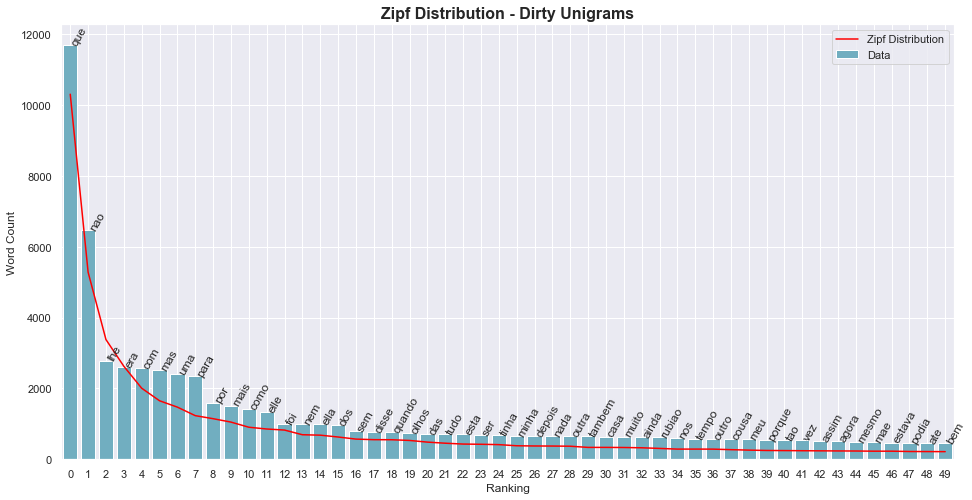

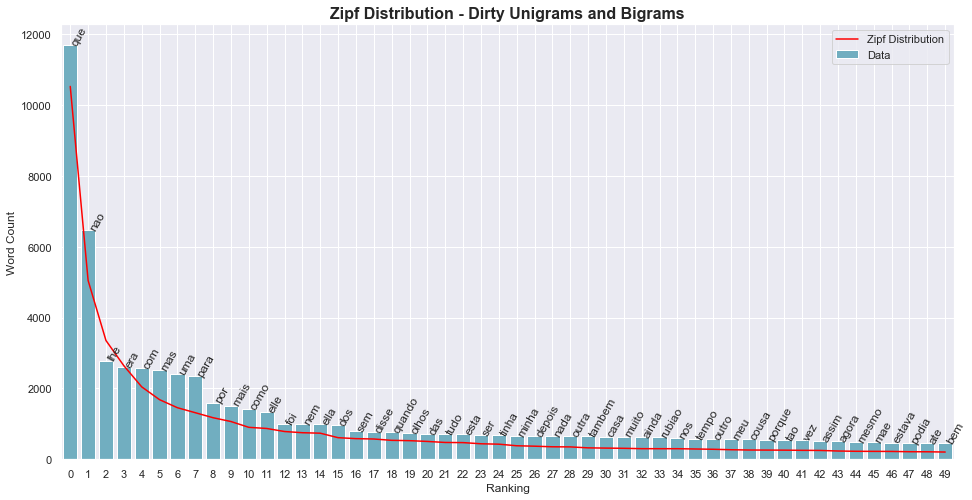

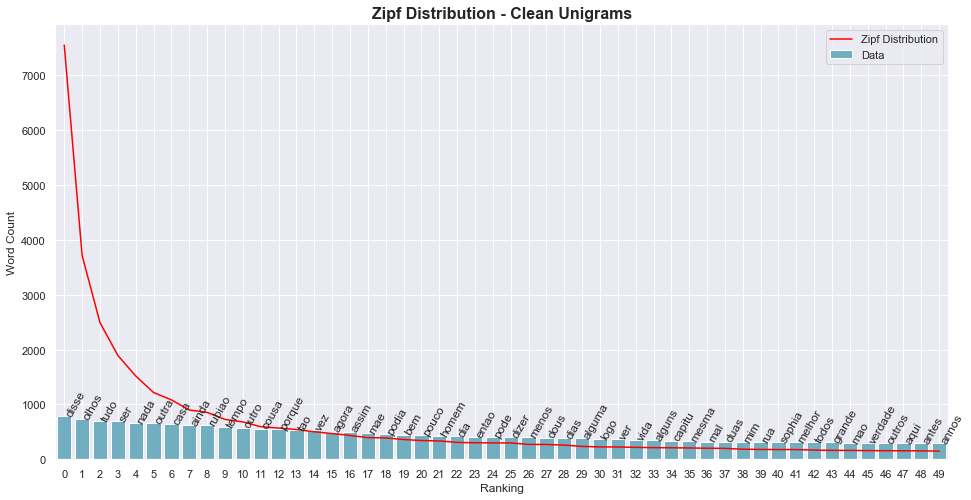

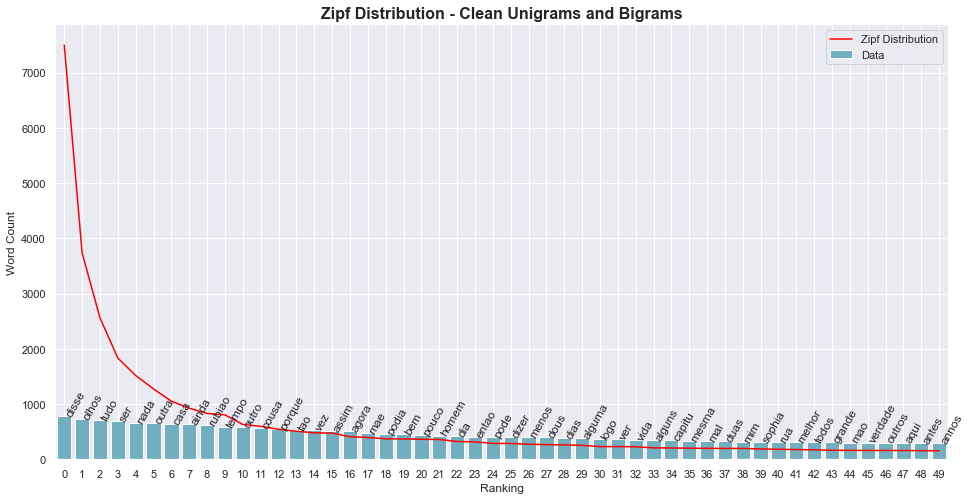

In [14]:
# com stop words (unigrams and bigrams)
plot_zipf(gimme_df_counts(words_dirty),1.001,title='Zipf Distribution - Dirty Unigrams')
plot_zipf(gimme_df_counts(bigrams_dirty),1.001,title='Zipf Distribution - Dirty Unigrams and Bigrams')

# sem stop words (unigrams and bigrams)
plot_zipf(gimme_df_counts(words_clean),1.001,title='Zipf Distribution - Clean Unigrams')
plot_zipf(gimme_df_counts(bigrams_clean),1.001,title='Zipf Distribution - Clean Unigrams and Bigrams')

# 5. TF-IDF

In [15]:
def gimme_tfidf(sentences,sublinear_tf=True):
    
    # list of list of strings -> list of strings
    corpus = [' '.join(sentence) for sentence in sentences]

    # TF-IDF
    vect1 = TfidfVectorizer(sublinear_tf=True)
    X1 = vect1.fit_transform(corpus)

    # TF
    vect2 = CountVectorizer()
    X2 = vect2.fit_transform(corpus)

    # dataframe
    df = pd.DataFrame(index=vect1.get_feature_names())
    df['tf'] = 1+array(log(X2.sum(axis=0)))[0]
    df['idf'] = vect1.idf_
    df['tfidf'] = array(X1.sum(axis=0))[0].tolist()

    return df

def plot_tfidf(df,top=15,title='TF-IDF'):

    # plot
    sns.set(style='darkgrid')
    fig, ax = plt.subplots(1,1,figsize=(16,8))

    sns.scatterplot(x=df.tfidf,
                    y=df.idf,
                    s=5*df.tf)

    # annotate
    df = df.sort_values('tfidf',ascending=False)
    for t in range(top):
        plt.annotate(df.index[t],(df.iloc[t].tfidf,df.iloc[t].idf+0.1),rotation=45)
        
    # labels
    #ax.set_xlim(0,cut)
    ax.set_title(title,fontweight='bold',fontsize='16')
    ax.set_xlabel('TFIDF')
    ax.set_ylabel('IDF')
    #plt.legend(loc="upper right")
    plt.grid(ls='-')

    # show
    plt.show()
    
plot_tfidf(gimme_tfidf(sentences_dirty),title='TFIDF - Dirty Unigrams')
plot_tfidf(gimme_tfidf(sentences_clean),title='TFIDF - Clean Unigrams')
plot_tfidf(gimme_tfidf(sentences_dirty_bigrams),title='TFIDF - Dirty Unigrams and Bigrams')
plot_tfidf(gimme_tfidf(sentences_clean_bigrams),title='TFIDF - Clean Unigrams and Bigrams')

MemoryError: 

# 7. Decompositions

## 7.1. Matricial decompositions

In [ ]:
# no easy lemmatizer in portuguese
# stemming
stemmer = SnowballStemmer('portuguese')
sentences_stem = [[stemmer.stem(word) for word in sentence] for sentence in sentences_clean_bigrams]

In [ ]:
# data
list_of_strings = [[''.join(word+' ' for word in sentence)][0] for sentence in sentences_stem]
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                   analyzer='word',
                                   min_df=0.001,
                                   max_df=0.5,
                                   sublinear_tf=True,
                                   use_idf=True)
ncomps=2
X = tfidf_vectorizer.fit_transform(list_of_strings)

In [ ]:
# display similars
terms = tfidf_vectorizer.get_feature_names()
def show_topics(component,vocabulary,topn=5):
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in component])
    return [', '.join(t) for t in topic_words]

### 7.2.1. Singular Value Decomposition (SVD)

In [ ]:
# svd decompostion
svd = TruncatedSVD(n_components=ncomps,
                   random_state=42)
U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

# top 5 values
print('SVD:')
print('Explained variance:',np.cumsum(svd.explained_variance_))
sup = sorted(show_topics(V, terms))
for i in range(min(5,len(sup))):
    print(i,sup[i])

### 7.2.2. Non-Negative Matrix Factorization (NMF)

In [ ]:
# nmf decompostion
nmf = NMF(n_components=ncomps,
          init='nndsvd',
          random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

# top 5 values
print('\nNMF:')
sup = sorted(show_topics(H, terms))
for i in range(min(5,len(sup))):
    print(i,sup[i])

### 7.2.3. Ploting words

In [ ]:
def plot_2d(X,Y,title='',xlabel='X',ylabel=''):

    # plot
    sns.set(style='darkgrid')
    fig, ax = plt.subplots(1,1,figsize=(16,8))

    sns.scatterplot(x=X,
                    y=Y)

    # labels
    ax.set_title(title,fontweight='bold',fontsize='16')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #plt.legend(loc="upper left")
    plt.grid(ls='-')

    # show
    plt.show()
    
plot_2d(X=U[:,0],
        Y=U[:,1],
        title='SVD - 2 Factors',
        xlabel='factor 1',
        ylabel='factor 2')

## 7.2. Gensim

### 7.2.1. BOW LDA

In [ ]:
# processing
processed_docs = sentences_stem
dictionary = gensim.corpora.Dictionary(sentences_stem)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
num_topics = 10

# model
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=num_topics,
                                       id2word=dictionary,
                                       passes=3)

# show
topics = lda_model.show_topics(num_topics=10,num_words=10,log=False,formatted=False)
for topic in topics:
    print('Topic:',topic[0])
    print('Words:',list(array(topic[1])[:,0]))
    print()

In [ ]:
def gimme_classifications(corpus,num_topics):
    # extract probabilities
    sup = np.zeros((len(corpus),num_topics))
    for i in range(len(corpus)):
        probs = lda_model[corpus[i]]
        for prob in probs:
            j, p = prob
            sup[i,j] = p
    # dataframe
    df = pd.DataFrame(sup)
    df['lda_mode'] = df.idxmax(axis=1)
    return df

#---------------------------------
df_mode = gimme_classifications(bow_corpus,num_topics)
freq = df_mode['lda_mode'].value_counts()
freq = freq/(freq.sum())
freq

### 7.2.2. TF-IDF LDA

In [ ]:
# processing
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# model
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,
                                             num_topics=num_topics,
                                             id2word=dictionary,
                                             passes=3)

# show
topics = lda_model_tfidf.show_topics(num_topics=10,num_words=10,log=False,formatted=False)
for topic in topics:
    print('Topic:',topic[0])
    print('Words:',list(array(topic[1])[:,0]))
    print()
    
#---------------------------------
df_mode = gimme_classifications(corpus_tfidf,num_topics)
freq = df_mode['lda_mode'].value_counts()
freq = freq/(freq.sum())
freq

### 3. LDA with LDAvis

In [ ]:
warnings.simplefilter("ignore", DeprecationWarning)

processed_docs = sentences_clean
# Initialise the count vectorizer with the English stop words
list_of_strings = [[''.join(word+' ' for word in sentence)][0] for sentence in processed_docs]
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(list_of_strings)

def print_topics(model, count_vectorizer, n_top_words=10):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print('Topic:',topic_idx)
        print('Words:',' '.join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()
        
# Create and fit the LDA model
lda = LDA(n_components=num_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print('LDA')
print_topics(lda, count_vectorizer)

In [ ]:
def compute_coherence_values(sentences,start=2,step=1,limit=10):
    # sentences = list of list of strings
    dictionary = corpora.Dictionary(sentences)
    corpus = [dictionary.doc2bow(sentence) for sentence in sentences]
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus,
                                           num_topics=num_topics,
                                           id2word=dictionary,
                                           passes=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=sentences,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
# initialize model
vocab = sentences_clean_bigrams

w2v_model = Word2Vec(window=20, 
                     hs=0,
                     negative=5, 
                     min_count=5,
                     workers=-1, 
                     iter=100)

w2v_model.build_vocab(vocab,
                      progress_per=10000)

w2v_model.train(sentences=sentences_clean_bigrams,
                total_examples=w2v_model.corpus_count,
                epochs=w2v_model.epochs)

print('Vocabulario:',len(w2v_model.wv.vocab))
#print(list(w2v_model.wv.vocab.keys())[:10])

# exemplo de palavras proximas
print('10 palavras mais parecidas com ARTE:',w2v_model.wv.most_similar(positive='arte',topn=10))
print('10 palavras mais parecidas com CAPITU:',w2v_model.wv.most_similar(positive='capitu',topn=10))

In [ ]:
w2v_model.wv.most_similar(positive=["virgili", "cub"], negative=["capitu"], topn=3)

In [ ]:
def plot_tsne(word,model,topn=20):
    
    if topn<0:topn=len(model.wv.vocab)
    arrays = np.empty((0, len(model.wv[word])), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word],topn=len(model.wv.vocab))

    # adds the vector for each of the closest words to the array
    for close_word in close_words:
        word_vector = model.wv.__getitem__([close_word[0]])
        word_labels.append(close_word[0])
        color_list.append('blue')
        arrays = np.append(arrays, word_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA (or the required)
    reduc = PCA(n_components = min(arrays.shape[0], arrays.shape[1], 50)).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2,
             random_state=0,
             perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]][:topn],
                       'y': [y for y in Y[:, 1]][:topn],
                       'words': word_labels[:topn],
                       'color': color_list[:topn]})
    df = df.sort_index(ascending=False)

    fig, _ = plt.subplots()
    fig.set_size_inches(12, 12)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']})

    # Adds annotations one by one with a loop
    for line in range(topn):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0][:topn].min()-50, Y[:, 0][:topn].max()+50)
    plt.ylim(Y[:, 1][:topn].min()-50, Y[:, 1][:topn].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))
    
plot_tsne('capitu',w2v_model,topn=20)